In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance

EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [68]:
# Reading the dataset
data = pd.read_csv("dataset/Hotel_Booking/hotel_bookings.csv")
data = data.sample(frac=0.2, replace=True, random_state=1).reset_index(drop=True)

data = data.drop(['company'], axis = 1)
data['children'] = data['children'].fillna(0)
data['hotel'] = data['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

data['arrival_date_month'] = data['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
def family(data):
    if ((data['adults'] > 0) & (data['children'] > 0)):
        val = 1
    elif ((data['adults'] > 0) & (data['babies'] > 0)):
        val = 1
    else:
        val = 0
    return val

def deposit(data):
    if ((data['deposit_type'] == 'No Deposit') | (data['deposit_type'] == 'Refundable')):
        return 0
    else:
        return 1
    
def feature(data):
    data["is_family"] = data.apply(family, axis = 1)
    data["total_customer"] = data["adults"] + data["children"] + data["babies"]
    data["deposit_given"] = data.apply(deposit, axis=1)
    data["total_nights"] = data["stays_in_weekend_nights"]+ data["stays_in_week_nights"]
    return data

data = feature(data)
# Information of these columns is also inside of new features, so it is better to drop them.
# I did not drop stays_nights features, I can't decide which feature is more important there.
data = data.drop(columns = ['adults', 'babies', 'children', 'deposit_type', 'reservation_status_date'])

indices = data.loc[pd.isna(data["country"]), :].index 
data = data.drop(data.index[indices])   
data = data.drop(columns = ['arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'agent'], axis = 1)

df1 = data.copy()
#one-hot-encoding
df1 = pd.get_dummies(data = df1, columns = ['meal', 'market_segment', 'distribution_channel',
                                            'reserved_room_type', 'assigned_room_type', 'customer_type', 'reservation_status'])
le = LabelEncoder()
df1['country'] = le.fit_transform(df1['country']) 
# There are more than 300 classes, so I wanted to use label encoder on this feature.

df2 = df1.drop(columns = ['reservation_status_Canceled', 'reservation_status_Check-Out', 'reservation_status_No-Show'], axis = 1)
df2.rename(columns={'market_segment_Offline TA/TO' : 'market_segment_Offline_TA_TO',
                    'market_segment_Online TA' : 'market_segment_Online_TA',
                    'distribution_channel_TA/TO' : 'distribution_channel_TA_TO',
                    'customer_type_Transient-Party' : 'customer_type_Transient_Party'}, inplace=True)

y = df2["is_canceled"]
X = df2.drop(["is_canceled"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

print("Train data: ", X_train.shape)
print("Test data: ", X_test.shape)

Train data:  (16648, 59)
Test data:  (7135, 59)


In [69]:
y_train.value_counts()

0    10537
1     6111
Name: is_canceled, dtype: int64

In [70]:
y_test.value_counts()

0    4504
1    2631
Name: is_canceled, dtype: int64

# Default Model

In [71]:
model_default = svm.SVC()
scores_default = cross_val_score(model_default, X=X_train, y=y_train, cv = FOLDS)
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)
get_performance(X_test, y_test, y_pred_default)

Performance on all data
Precision: 0.679502614215771
Recall: 0.6850735809390329
F1 Score: 0.6471423330777778


(0.679502614215771, 0.6850735809390329, 0.6471423330777778, None)

In [72]:
pd.DataFrame(y_pred_default).value_counts()

0    5951
1    1184
dtype: int64

# SMOTE Oversampling

In [73]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
model_SMOTE = svm.SVC()
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)
get_performance(X_test, y_test, y_pred_SMOTE)

Performance on all data
Precision: 0.6967915693156654
Recall: 0.6908199018920813
F1 Score: 0.6931537790074772


(0.6967915693156654, 0.6908199018920813, 0.6931537790074772, None)

In [74]:
print(X_train_sm.shape,y_train_sm.shape)

(21074, 59) (21074,)


# MAPS

In [75]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [76]:
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

In [77]:
def mispredict_label(row):
    if row['is_canceled'] == row['pred']:
        return False
    return True

In [78]:
default_result_copy = default_result.copy()
X_test_copy = X_test.copy()
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)

In [79]:
# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Generate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target)

print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

MMD Spent: 5.460958242416382 BGMD Spent: 5.17272686958313


([[0.4959695476936857, 'required_car_parking_spaces<=0'],
  [0.016659359929855327, 'total_nights>14'],
  [0.014072119613016711, 'stays_in_week_nights>11']],
 [[0.4959695476936857, 'required_car_parking_spaces<=0'],
  [0.016659359929855327, 'total_nights>14'],
  [0.014072119613016711, 'stays_in_week_nights>11']])

In [80]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['is_canceled'])

In [81]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 101)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
    print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=upweight)

    c = Counter(weights)
    print(c.items())

    MAPS_model = svm.SVC()
    scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
    MAPS_model.fit(X_train, y_train, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0])
    recall_all.append(total_result[1])
    f1_all.append(total_result[2])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, average='weighted')
    acc_mispredicted.append(MAPS_MD_metric[0])
    recall_mispredicted.append(MAPS_MD_metric[1])
    f1_mispredicted.append(MAPS_MD_metric[2])
    
    if total_result[2] > best_f1_all:
        best_f1_all = total_result[2]
        best_weight_all = upweight;
    if MAPS_MD_metric[2] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2]
        best_weight_mis = upweight

Upweight_value:  1
dict_items([(1, 16648)])
Performance on all data
Precision: 0.679502614215771
Recall: 0.6850735809390329
F1 Score: 0.6471423330777778
Upweight_value:  2
dict_items([(2, 15587), (1, 1061)])
Performance on all data
Precision: 0.6855978336750553
Recall: 0.6926419060967064
F1 Score: 0.6628531544972804
Upweight_value:  3
dict_items([(3, 15587), (1, 1061)])
Performance on all data
Precision: 0.6981883511733069
Recall: 0.7042747021723896
F1 Score: 0.6801883148552464
Upweight_value:  4
dict_items([(4, 15587), (1, 1061)])
Performance on all data
Precision: 0.7006240367744684
Recall: 0.7070777855641205
F1 Score: 0.6851821357776238
Upweight_value:  5
dict_items([(5, 15587), (1, 1061)])
Performance on all data
Precision: 0.7117030526937111
Recall: 0.7159074982480729
F1 Score: 0.6945818134144695
Upweight_value:  6
dict_items([(6, 15587), (1, 1061)])
Performance on all data
Precision: 0.7128773670315883
Recall: 0.7173090399439384
F1 Score: 0.6969169470899427
Upweight_value:  7
dic

Upweight_value:  51
dict_items([(51, 15587), (1, 1061)])
Performance on all data
Precision: 0.7309860817402547
Recall: 0.7279607568325158
F1 Score: 0.7035455552128451
Upweight_value:  52
dict_items([(52, 15587), (1, 1061)])
Performance on all data
Precision: 0.7313555653892104
Recall: 0.7282410651716889
F1 Score: 0.7038510208952636
Upweight_value:  53
dict_items([(53, 15587), (1, 1061)])
Performance on all data
Precision: 0.7313555653892104
Recall: 0.7282410651716889
F1 Score: 0.7038510208952636
Upweight_value:  54
dict_items([(54, 15587), (1, 1061)])
Performance on all data
Precision: 0.7313555653892104
Recall: 0.7282410651716889
F1 Score: 0.7038510208952636
Upweight_value:  55
dict_items([(55, 15587), (1, 1061)])
Performance on all data
Precision: 0.7315785342187899
Recall: 0.7283812193412754
F1 Score: 0.7039720050991203
Upweight_value:  56
dict_items([(56, 15587), (1, 1061)])
Performance on all data
Precision: 0.7315785342187899
Recall: 0.7283812193412754
F1 Score: 0.703972005099120

Performance on all data
Precision: 0.7360982838665849
Recall: 0.7325858444288718
F1 Score: 0.7093596136492506


Best weight on all is:  100
Best weight on misprediction area is:  100


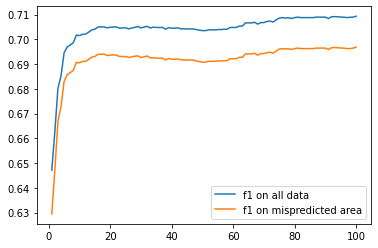

In [82]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()

In [83]:
from helper import get_mispredicted_region_test

weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=best_weight_mis)
c = Counter(weights)
MAPS_model = svm.SVC()
scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
MAPS_model.fit(X_train, y_train, sample_weight = weights)
y_pred_MAPS = MAPS_model.predict(X_test)
get_performance(X_test, y_test, y_pred_MAPS)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='is_canceled')

Performance on all data
Precision: 0.7360982838665849
Recall: 0.7325858444288718
F1 Score: 0.7093596136492506
y_actual_MD: 6685
y_predict_default_MD: 6685
y_pred_SMOTE_MD: 6685
y_pred_MAPS_MD: 6685

Default: (0.6718406104250724, 0.668661181750187, 0.629449196338195, None)
SMOTE: (0.6913145646002297, 0.6893044128646223, 0.6901819622676353, None)
MAPS: (0.7326918985323376, 0.7208676140613314, 0.6968679842874989, None)


In [84]:
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
out.to_csv('MAPS_Hotel_Bookings.csv')

# Just Train Twice

In [85]:
from helper import generate_JTT_Weights

In [86]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 29)

model_JTT = svm.SVC()
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)
get_performance(X_val, y_val, y_pred_JTT_val)

Performance on all data
Precision: 0.6896229105275509
Recall: 0.6922096832908627
F1 Score: 0.6526332351556602


(0.6896229105275509, 0.6922096832908627, 0.6526332351556602, None)

In [87]:
grid_upweights_JTT = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
f1_all_JTT = [];

for upweight in grid_upweights_JTT:
    weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = svm.SVC()
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    f1_all_JTT.append(total_result_JTT[2])
    if total_result_JTT[2] > best_f1_all_JTT:
        best_f1_all_JTT = total_result_JTT[2]
        best_weight_all_JTT = upweight;

Performance on all data
Precision: 0.6912652617066869
Recall: 0.6880168185003503
F1 Score: 0.6424075301909988
Performance on all data
Precision: 0.6913181773518197
Recall: 0.6887175893482831
F1 Score: 0.6442387676366454
Performance on all data
Precision: 0.6920316650083659
Recall: 0.6892782060266293
F1 Score: 0.64507316270783
Performance on all data
Precision: 0.6901765877449775
Recall: 0.6891380518570428
F1 Score: 0.6464900563342068
Performance on all data
Precision: 0.6891762472966318
Recall: 0.6888577435178697
F1 Score: 0.6467358419327723
Performance on all data
Precision: 0.686210648524029
Recall: 0.6877365101611773
F1 Score: 0.6467655948222611
Performance on all data
Precision: 0.687156787608526
Recall: 0.6881569726699369
F1 Score: 0.6469184724221365
Performance on all data
Precision: 0.6865197123084338
Recall: 0.6882971268395235
F1 Score: 0.6480400281721402
Performance on all data
Precision: 0.6851924448464529
Recall: 0.6877365101611773
F1 Score: 0.6479515630739937
Performance on

JTT Best weight on all is:  100
JTT Best f1 score on all:  0.6483124164884712


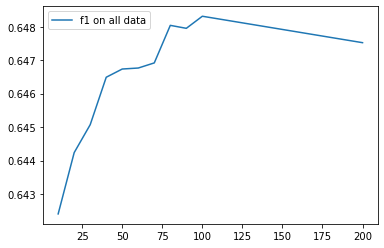

In [88]:
print("JTT Best weight on all is: ", best_weight_all_JTT)
print("JTT Best f1 score on all: ", best_f1_all_JTT)
plt.plot(grid_upweights_JTT, f1_all_JTT, label = "f1 on all data")
plt.legend()
plt.show()

In [89]:
weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = best_weight_all_JTT)
    
#combine train and validate data
weights = np.concatenate((np.ones(len(X_train_1st)), weights))
y_train_2nd = np.concatenate((y_train_1st, y_val))
X_train_2nd = pd.concat([X_train_1st, X_val])
X_train_2nd['val_weight'] = weights
X_train_2nd['target'] = y_train_2nd
X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
weights = X_train_2nd['val_weight'].to_list()
y_train_2nd = X_train_2nd['target']
X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)

model_JTT = svm.SVC()
scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
y_pred_JTT = model_JTT.predict(X_test)
total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_JTT, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='is_canceled')

Performance on all data
Precision: 0.6862841768112322
Recall: 0.6882971268395235
F1 Score: 0.6483124164884712
y_actual_MD: 6685
y_predict_default_MD: 6685
y_pred_SMOTE_MD: 6685
y_pred_MAPS_MD: 6685

Default: (0.6789252355728753, 0.6716529543754675, 0.6303613682804409, None)
SMOTE: (0.6913145646002297, 0.6893044128646223, 0.6901819622676353, None)
MAPS: (0.7326918985323376, 0.7208676140613314, 0.6968679842874989, None)
